In [ ]:
import torch
import torch.nn as nn

In [ ]:
# 배치크기 * 채널 * 높이 * 너비 의 크기의 텐서 선언
inputs = torch.Tensor(1,1,28,28)
print('텐서의 크기: {}'.format(inputs.shape))

텐서의 크기: torch.Size([1, 1, 28, 28])


# 합성곱층과 풀링 선언하기

In [ ]:
conv1 = nn.Conv2d(1, 32, 3, padding = 1 )
print(conv1)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
conv2 = nn.Conv2d(32, 64, 3, padding = 1 )
print(conv2)

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
pool = nn.MaxPool2d(2)
print(pool)

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


# 구현체를 연결하여 모델 만들기

In [ ]:
out = conv1(inputs)
print(out.shape)

torch.Size([1, 32, 28, 28])


In [ ]:
out = pool(out)
print(out.shape)

torch.Size([1, 32, 14, 14])


In [ ]:
out = conv2(out)
print(out.shape)

torch.Size([1, 64, 14, 14])


In [ ]:
out.size(0)

1

In [ ]:
out.size(1)

64

In [ ]:
out.size(2)

14

In [ ]:
out.size(3)

14

In [ ]:
# 첫번째 차원인 배치 차원은 그대로 두고 나머지는 펼쳐라
out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 12544])


In [ ]:
fc = nn.Linear(12544, 10) # input_dim = 3,136, output_dim = 10
out = fc(out)
print(out.shape)

torch.Size([1, 10])


# CNN으로 MNIST 분류하기

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [ ]:
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw




Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [ ]:
len(data_loader)

600

In [ ]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        # ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        # ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

In [ ]:
# CNN 모델 정의
model = CNN().to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 600


In [ ]:
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X) # 모델 예측값
        
        cost = criterion(hypothesis, Y) # 비용
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.220102176
[Epoch:    2] cost = 0.0609714426
[Epoch:    3] cost = 0.0459452197
[Epoch:    4] cost = 0.0367026851
[Epoch:    5] cost = 0.0301299915
[Epoch:    6] cost = 0.0262607373
[Epoch:    7] cost = 0.0207152851
[Epoch:    8] cost = 0.018461559
[Epoch:    9] cost = 0.0154219978
[Epoch:   10] cost = 0.0134396609
[Epoch:   11] cost = 0.0117522581
[Epoch:   12] cost = 0.00811791234
[Epoch:   13] cost = 0.00904283021
[Epoch:   14] cost = 0.0053165406
[Epoch:   15] cost = 0.0060720155


In [ ]:
# 학습을 진행하지 않을 것이므로 torch.no_grad()
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9855999946594238


In [ ]:
type(X_test[0])

torch.Tensor

In [ ]:
import numpy as np
def im_convert(tensor):
  # 복제하고, 자동미분 끄고, numpy로
  image = tensor.clone().detach().numpy()
  # 데이터 형태는 color channel 1 28 px 28 px , 즉 1, 28, 28로 되어있음
  # 이거를 28, 28, 1 로 변경
  image = image.transpose(1, 2, 0)
  # denormalize
  image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
  # 데이터를 0과 1사이로만 있도록 보정
  image = image.clip(0, 1)
  return image
im_convert(X_test[0])

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

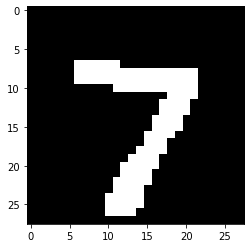

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(im_convert(X_test[0]), cmap = 'gray')

In [32]:
prediction = model(X_test)
correct_prediction = torch.argmax(prediction, 1)
correct_prediction[0]

tensor(7)